### Text Analysis(Sentiment analysis & Topic Modeling)

In [4]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from gensim import corpora
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import talib as ta
import numpy as np
# import pynance as pn
import matplotlib.pyplot as plt
# import pyfolio as pf

In [5]:
import sys
import os
import pandas as pd
nltk.download('vader_lexicon')
sys.path.append(os.path.abspath('../Scripts'))


def perform_sentiment_analysis(df):
    # Initialize VADER SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()
    
    # Apply sentiment analysis on the 'headline' column
    df['sentiment'] = df['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])

    # Categorize the sentiment into positive, negative, or neutral
    df['sentiment_label'] = df['sentiment'].apply(lambda score: 'positive' if score > 0.05 else ('negative' if score < -0.05 else 'neutral'))

    print("Sentiment analysis complete. Here are some samples:")
    print(df[['headline', 'sentiment', 'sentiment_label']].head())

    return df


def perform_topic_modeling_gensim(df, num_topics=5, num_words=10, sample_size=None):
    # Subsample the data if a sample size is provided
    if sample_size:
        df = df.sample(n=sample_size, random_state=42)

    # Initialize CountVectorizer for basic keyword extraction
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(df['headline'])
    vocab = vectorizer.get_feature_names_out()

    # Convert to gensim format
    corpus = [[(i, freq) for i, freq in zip(doc.indices, doc.data)] for doc in dtm]
    id2word = corpora.Dictionary([vocab])

    # Fit LDA model using gensim
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=15, random_state=42)

    # Print topics
    topics = lda_model.print_topics(num_topics=num_topics, num_words=num_words)
    for topic in topics:
        print(topic)

    return lda_model, corpus, id2word



def analyze_publication_frequency(df):
    # Print the original data type and a few rows of the date column
    print("Original 'date' column data type and sample data:")
    print(df['date'].dtype)
    print(df['date'].head())

    # Convert the date column to datetime, handling timezone info correctly
    df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')

    # Print the data types after conversion
    print("\nData type of 'date' column after conversion:")
    print(df['date'].dtype)

    # Print the first few rows of the date column after conversion
    print("\nConverted 'date' column:")
    print(df['date'])
    # Print the data type and some sample data to confirm the conversion
    print("\nData type of 'date' column after conversion:")
    print(df['date'].dtype)
    print("\nSample of 'date' column after conversion:")
    print(df['date'].head())

    # Check if any NaT values were created during conversion
    print("\nNumber of NaT values in 'date' column after conversion:")
    print(df['date'].isna().sum())

    # Drop any rows with NaT in the 'date' column
    df = df.dropna(subset=['date'])

    # Confirm no NaT values remain
    print("\nConfirming no NaT values remain in 'date' column:")
    print(df['date'].isna().sum())

    # Aggregate the data by date
    df['publication_date'] = df['date'].dt.date
    publication_counts = df['publication_date'].value_counts().sort_index()

    # Plot the time series of publication frequency as a line plot
    plt.figure(figsize=(12, 6))
    plt.plot(publication_counts, linestyle='-', marker=None, color='b')
    plt.title('Publication Frequency Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Articles Published')
    plt.grid(True)
    plt.show()

    # Return the publication counts for further analysis if needed
    return publication_counts


def analyze_publishers(df):
    # Count the number of articles per publisher
    publisher_counts = df['publisher'].value_counts()
    
    # Display the top 10 publishers
    print("Top 10 Publishers by Number of Articles:")
    print(publisher_counts.head(10))

    return publisher_counts

def visualize_sentiment_distribution(df):
    # Count the occurrences of each sentiment category
    sentiment_counts = df['sentiment_label'].value_counts()
    
    # Plot a bar chart of the sentiment distribution
    plt.figure(figsize=(10, 6))
    sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
    plt.title('Distribution of News Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Articles')
    plt.xticks(rotation=0)
    plt.show()


def visualize_sentiment_by_publisher(df, top_n=5):
    # Select the top N publishers
    top_publishers = df['publisher'].value_counts().head(top_n).index
    filtered_df = df[df['publisher'].isin(top_publishers)]
    
    # Group by publisher and sentiment label, then count
    sentiment_by_publisher = filtered_df.groupby(['publisher', 'sentiment_label']).size().unstack(fill_value=0)
    
    # Plot the sentiment distribution by publisher
    sentiment_by_publisher.plot(kind='bar', stacked=True, figsize=(12, 8))
    plt.title('Sentiment Distribution by Publisher')
    plt.xlabel('Publisher')
    plt.ylabel('Number of Articles')
    plt.xticks(rotation=45)
    plt.show()



def analyze_email_domains(df):
    # Identify publishers that look like email addresses
    email_publishers = df[df['publisher'].str.contains('@', na=False)]
    
    # Extract domain names from email addresses
    email_publishers['domain'] = email_publishers['publisher'].apply(lambda x: re.findall(r'@([\w\.-]+)', x)[0])
    
    # Count the number of articles per domain
    domain_counts = email_publishers['domain'].value_counts()
    
    # Display the top 10 domains
    print("Top 10 Domains by Number of Articles (from email addresses):")
    print(domain_counts.head(10))
    
    return domain_counts



def load_stock_data(file_path):
    # Load the stock price data
    df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    
    # Ensure the data has the necessary columns
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    if not all(column in df.columns for column in required_columns):
        raise ValueError(f"Data must include the following columns: {required_columns}")
    
    
    return df



def apply_technical_indicators(df):
    # Calculate Simple Moving Average (SMA)
    df['SMA_20'] = ta.SMA(df['Close'], timeperiod=20)
    
    # Calculate Relative Strength Index (RSI)
    df['RSI_14'] = ta.RSI(df['Close'], timeperiod=14)
    
    # Calculate Moving Average Convergence Divergence (MACD)
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = ta.MACD(df['Close'], 
                                                              fastperiod=12, 
                                                              slowperiod=26, 
                                                              signalperiod=9)
    

    
    return df


def calculate_financial_metrics(df):
    # Example: Calculate daily returns using PyNance
    df['daily_return'] = df['Close'].pct_change()
    

    return df



def visualize_stock_data(df):
    plt.figure(figsize=(14, 7))
    
    # Plot Closing Price
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df['Close'], label='Close Price')
    plt.plot(df.index, df['SMA_20'], label='20-Day SMA')
    plt.title('Stock Closing Price and SMA')
    plt.legend()
    
    # Plot RSI
    plt.subplot(3, 1, 2)
    plt.plot(df.index, df['RSI_14'], label='RSI (14)')
    plt.axhline(y=70, color='r', linestyle='--')
    plt.axhline(y=30, color='g', linestyle='--')
    plt.title('RSI (14)')
    plt.legend()
    
    # Plot MACD
    plt.subplot(3, 1, 3)
    plt.plot(df.index, df['MACD'], label='MACD')
    plt.plot(df.index, df['MACD_signal'], label='Signal Line')
    plt.bar(df.index, df['MACD_hist'], label='MACD Histogram')
    plt.title('MACD')
    plt.legend()
    
    plt.tight_layout()
    plt.show()






[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment analysis complete. Here are some samples:
                                            headline  sentiment  \
0            Stocks That Hit 52-Week Highs On Friday      0.000   
1         Stocks That Hit 52-Week Highs On Wednesday      0.000   
2                      71 Biggest Movers From Friday      0.000   
3       46 Stocks Moving In Friday's Mid-Day Session      0.000   
4  B of A Securities Maintains Neutral on Agilent...      0.296   

  sentiment_label  
0         neutral  
1         neutral  
2         neutral  
3         neutral  
4        positive  
difference in the type of news they report based on sentiment analysis


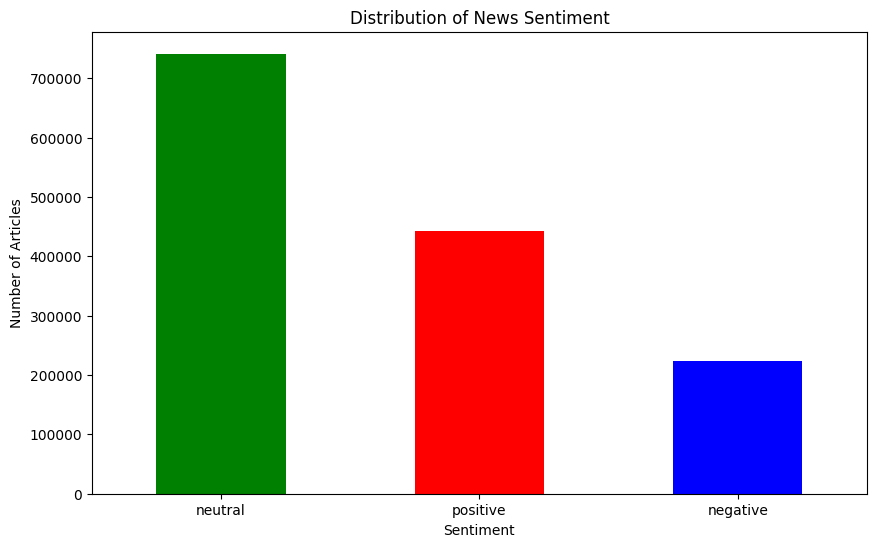

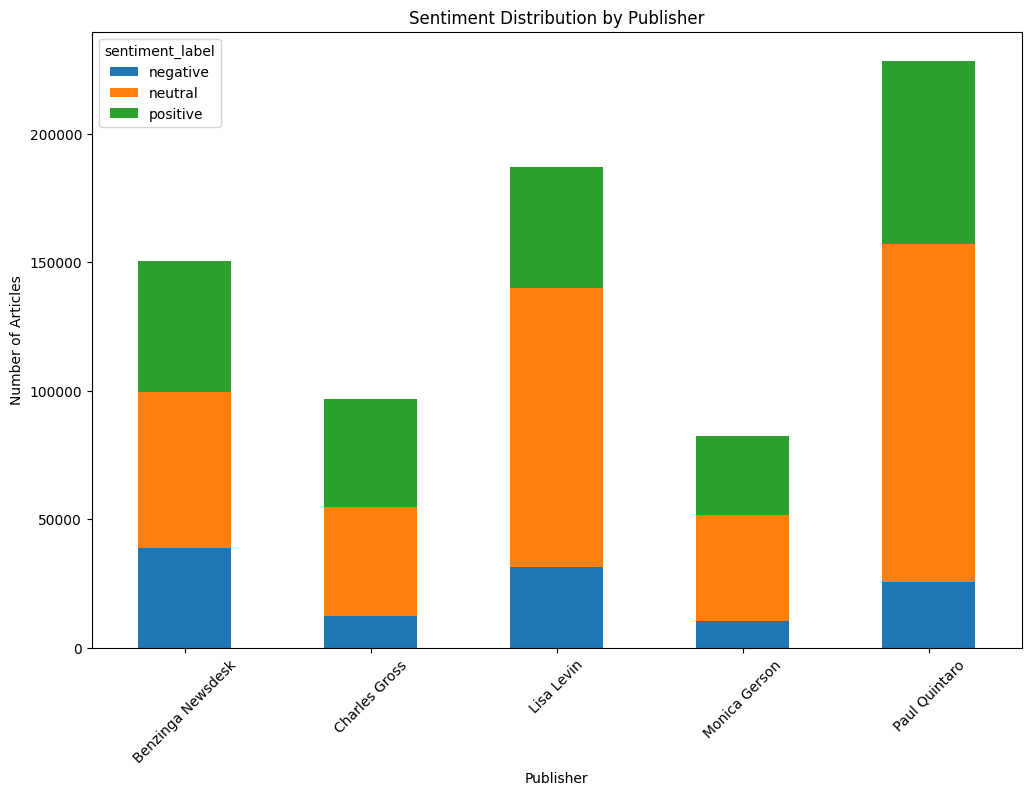

(0, '0.043*"week" + 0.041*"52" + 0.034*"stocks" + 0.022*"upgrades" + 0.021*"new" + 0.018*"benzinga" + 0.015*"set" + 0.014*"hit" + 0.012*"high" + 0.011*"yesterday"')
(1, '0.025*"shares" + 0.017*"update" + 0.015*"estimate" + 0.014*"sales" + 0.013*"says" + 0.011*"q1" + 0.011*"eps" + 0.010*"year" + 0.010*"announces" + 0.010*"yoy"')
(2, '0.044*"stocks" + 0.041*"market" + 0.027*"session" + 0.025*"moving" + 0.023*"earnings" + 0.019*"mid" + 0.018*"pre" + 0.015*"morning" + 0.013*"tuesday" + 0.013*"scheduled"')
(3, '0.030*"trading" + 0.025*"shares" + 0.020*"higher" + 0.016*"initiates" + 0.013*"coverage" + 0.013*"update" + 0.013*"market" + 0.011*"lower" + 0.011*"stocks" + 0.010*"today"')
(4, '0.051*"vs" + 0.045*"est" + 0.034*"eps" + 0.031*"reports" + 0.022*"maintains" + 0.022*"raises" + 0.018*"target" + 0.018*"price" + 0.017*"sales" + 0.015*"buy"')


In [6]:
# Load the raw analyst ratings data
raw_analyst_ratings_df = pd.read_csv('../data/raw_analyst_ratings.csv')

# Perform Sentiment Analysis
sentiment_df = perform_sentiment_analysis(raw_analyst_ratings_df)
# Visualize the sentiment distribution
print("difference in the type of news they report based on sentiment analysis")
visualize_sentiment_distribution(raw_analyst_ratings_df)
# Visualize sentiment distribution by top publishers
visualize_sentiment_by_publisher(raw_analyst_ratings_df, top_n=5)

# Perform Topic Modeling
lda_model_gensim, corpus, id2word = perform_topic_modeling_gensim(raw_analyst_ratings_df, num_topics=5, num_words=10, sample_size=1000)

## Time Series Analysis

Original 'date' column data type and sample data:
object
0    2020-06-05 10:30:54-04:00
1    2020-06-03 10:45:20-04:00
2    2020-05-26 04:30:07-04:00
3    2020-05-22 12:45:06-04:00
4    2020-05-22 11:38:59-04:00
Name: date, dtype: object

Data type of 'date' column after conversion:
datetime64[ns, UTC]

Converted 'date' column:
0         2020-06-05 14:30:54+00:00
1         2020-06-03 14:45:20+00:00
2         2020-05-26 08:30:07+00:00
3         2020-05-22 16:45:06+00:00
4         2020-05-22 15:38:59+00:00
                     ...           
1407323                         NaT
1407324                         NaT
1407325                         NaT
1407326                         NaT
1407327                         NaT
Name: date, Length: 1407328, dtype: datetime64[ns, UTC]

Data type of 'date' column after conversion:
datetime64[ns, UTC]

Sample of 'date' column after conversion:
0   2020-06-05 14:30:54+00:00
1   2020-06-03 14:45:20+00:00
2   2020-05-26 08:30:07+00:00
3   2020-05-22 16:4

C:\Users\hp\AppData\Local\Temp\ipykernel_18464\507773814.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['publication_date'] = df['date'].dt.date


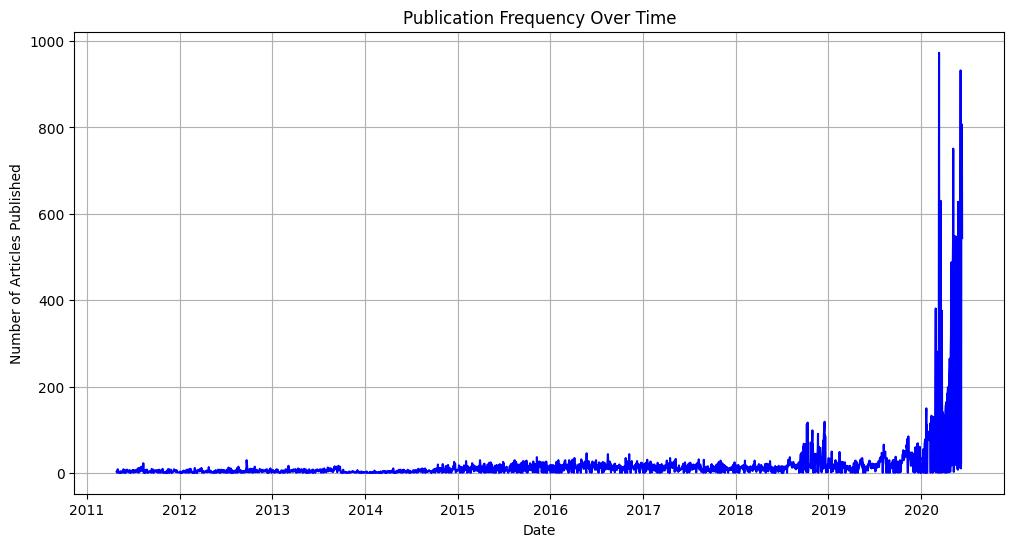

In [7]:
# Import necessary modules
import sys
import os
sys.path.append(os.path.abspath('../Scripts'))
import pandas as pd

# Load the raw analyst ratings data
raw_analyst_ratings_df = pd.read_csv('../data/raw_analyst_ratings.csv')

# Analyze publication frequency
publication_counts = analyze_publication_frequency(raw_analyst_ratings_df)

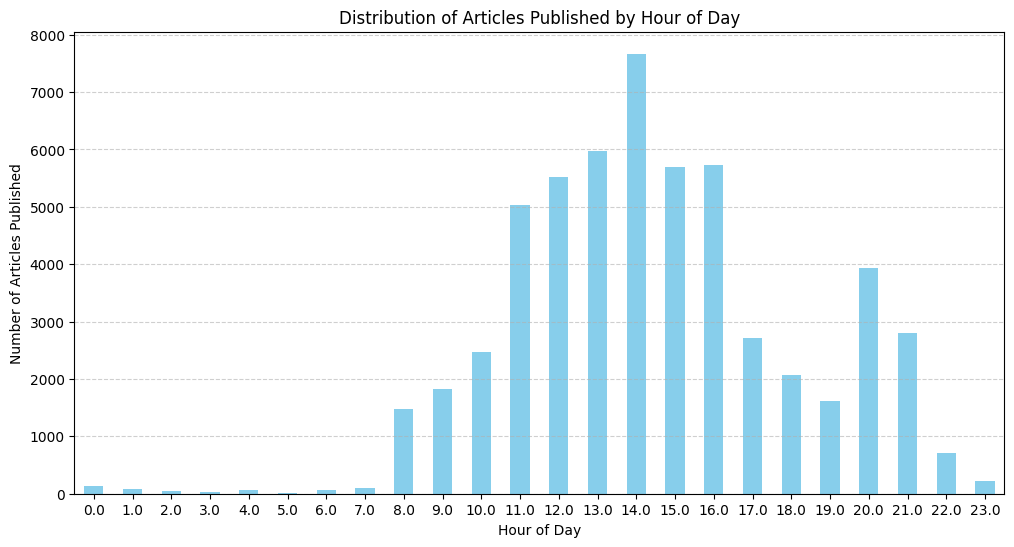

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (replace this with your actual data loading method)
df = pd.read_csv('../data/raw_analyst_ratings.csv')

# Attempt to convert 'date' column to datetime, handling errors
df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')
# Extract the hour from the 'date' column
df['hour'] = df['date'].dt.hour

# Group by hour to see the frequency of articles published at each hour
hourly_distribution = df['hour'].value_counts().sort_index()

# Plot the distribution of articles by hour
plt.figure(figsize=(12, 6))
hourly_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Articles Published by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Articles Published')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [9]:
# Load the dataset
import sys
import os
sys.path.append(os.path.abspath('../Scripts'))
import pandas as pd
raw_analyst_ratings_df = pd.read_csv('../data/raw_analyst_ratings.csv')

# Analyze publishers
publisher_counts = analyze_publishers(raw_analyst_ratings_df)

Top 10 Publishers by Number of Articles:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


In [10]:
# Analyze email domains if publishers are listed as email addresses
import sys
import os
sys.path.append(os.path.abspath('../Scripts'))

import pandas as pd
raw_analyst_ratings_df = pd.read_csv('../data/raw_analyst_ratings.csv')
email_domain_counts = analyze_email_domains(raw_analyst_ratings_df)

Top 10 Domains by Number of Articles (from email addresses):
domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


C:\Users\hp\AppData\Local\Temp\ipykernel_18464\507773814.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  email_publishers['domain'] = email_publishers['publisher'].apply(lambda x: re.findall(r'@([\w\.-]+)', x)[0])



AAPL :



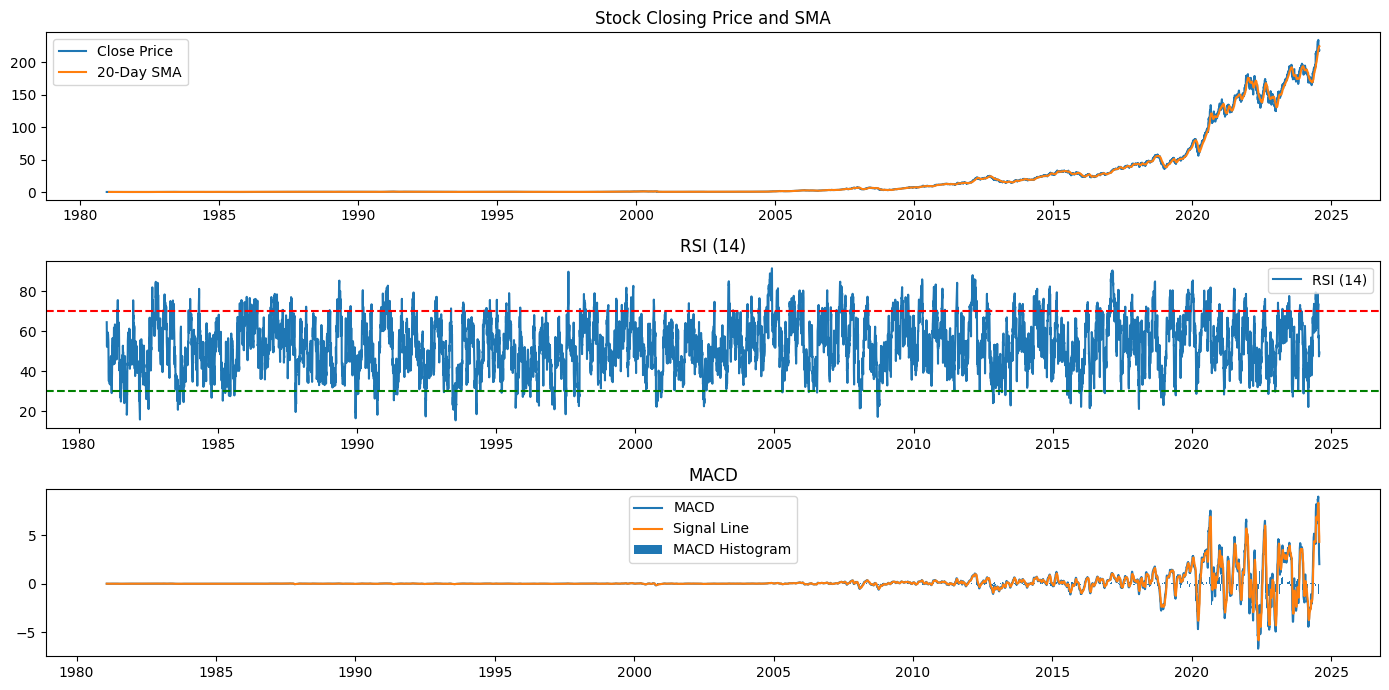

None





TSLA :



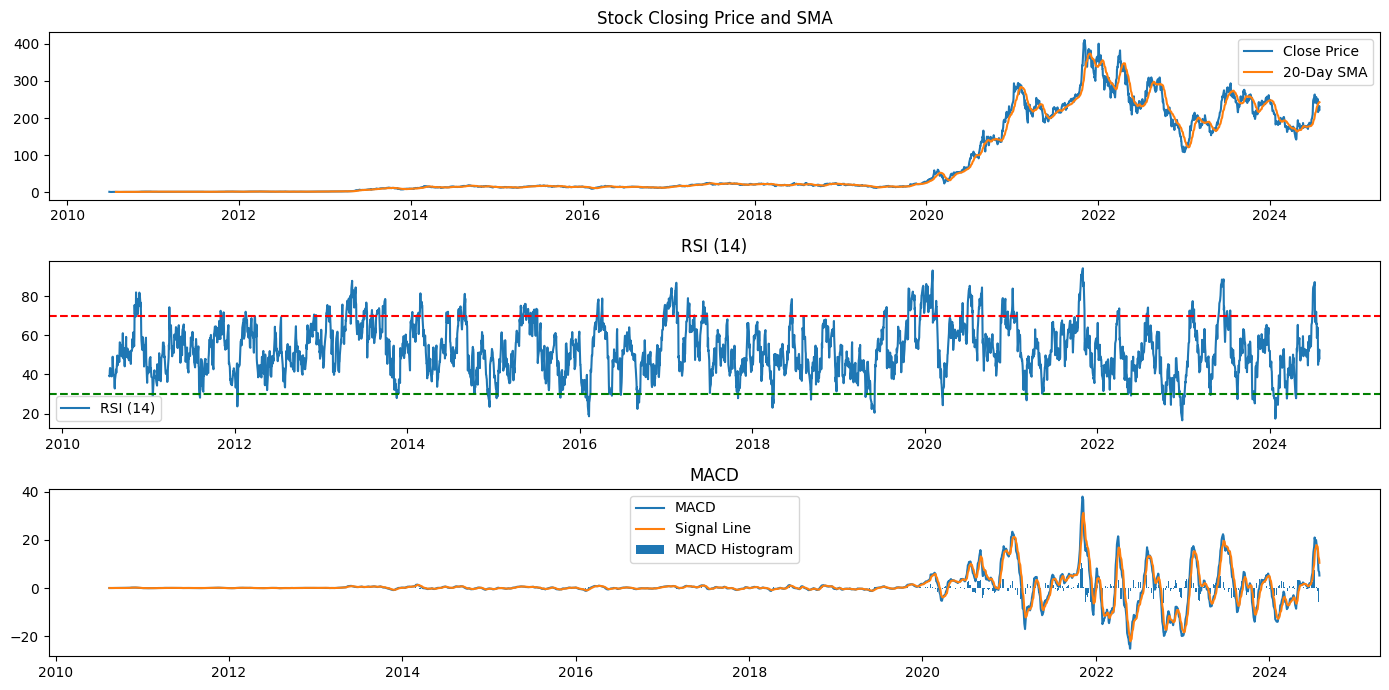

None





AMZN :



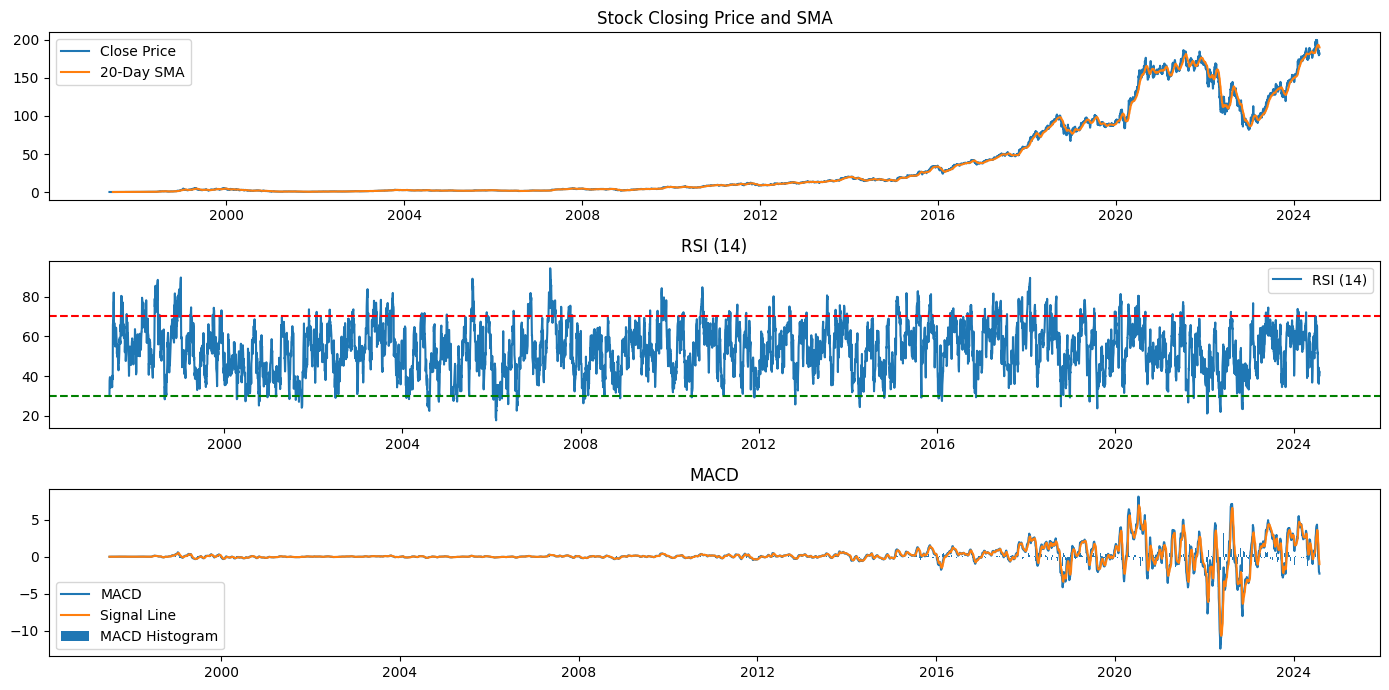

None





GOOG :



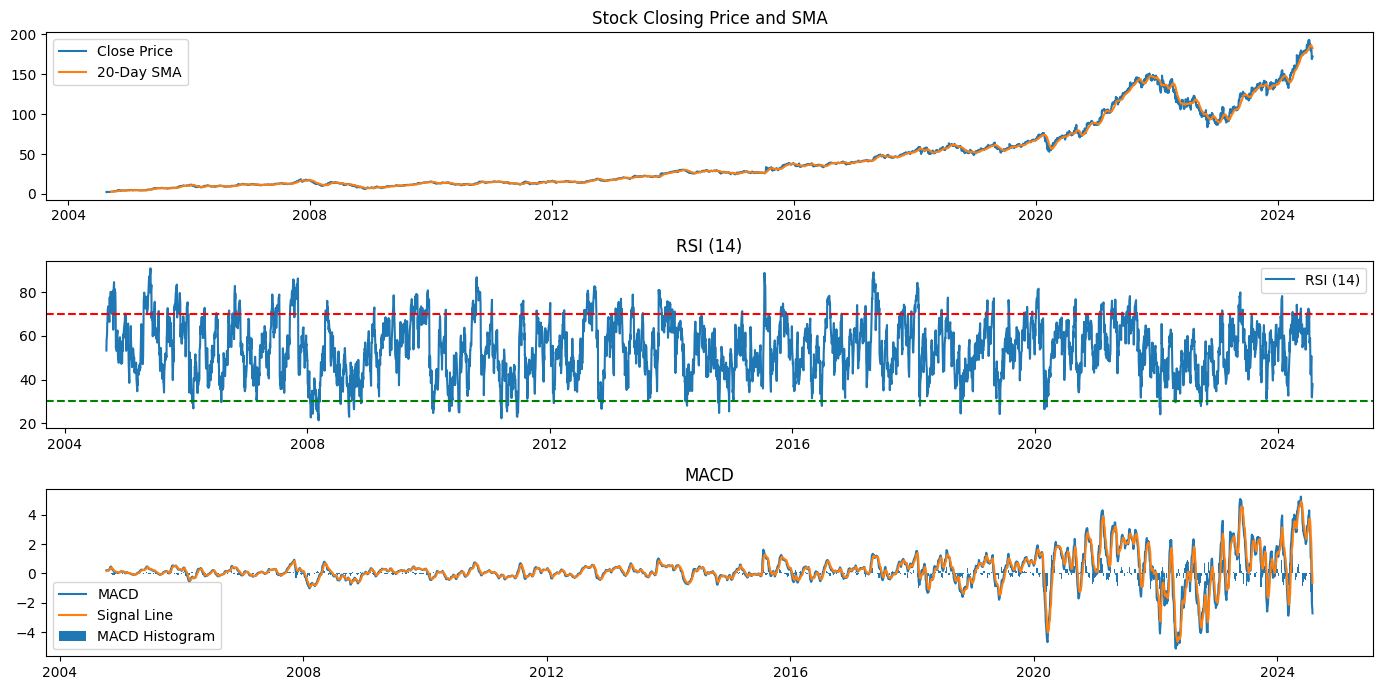

None





META :



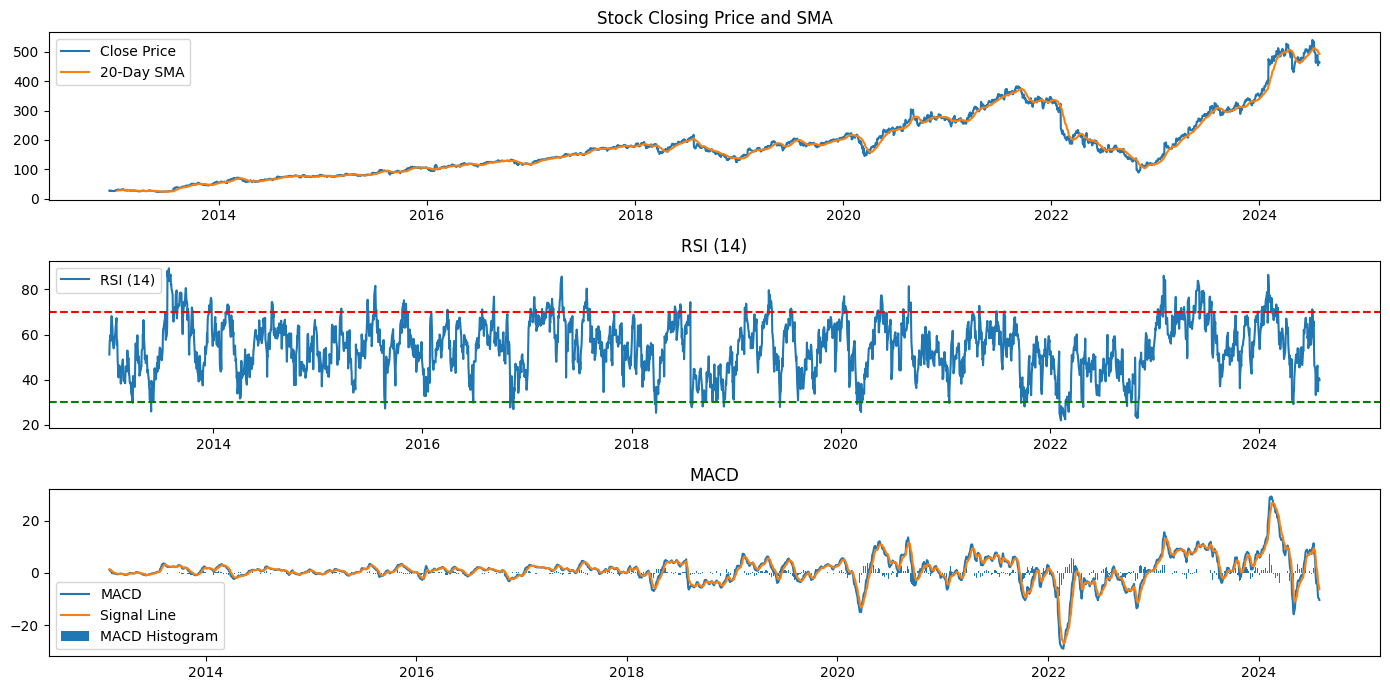

None





MSFT :



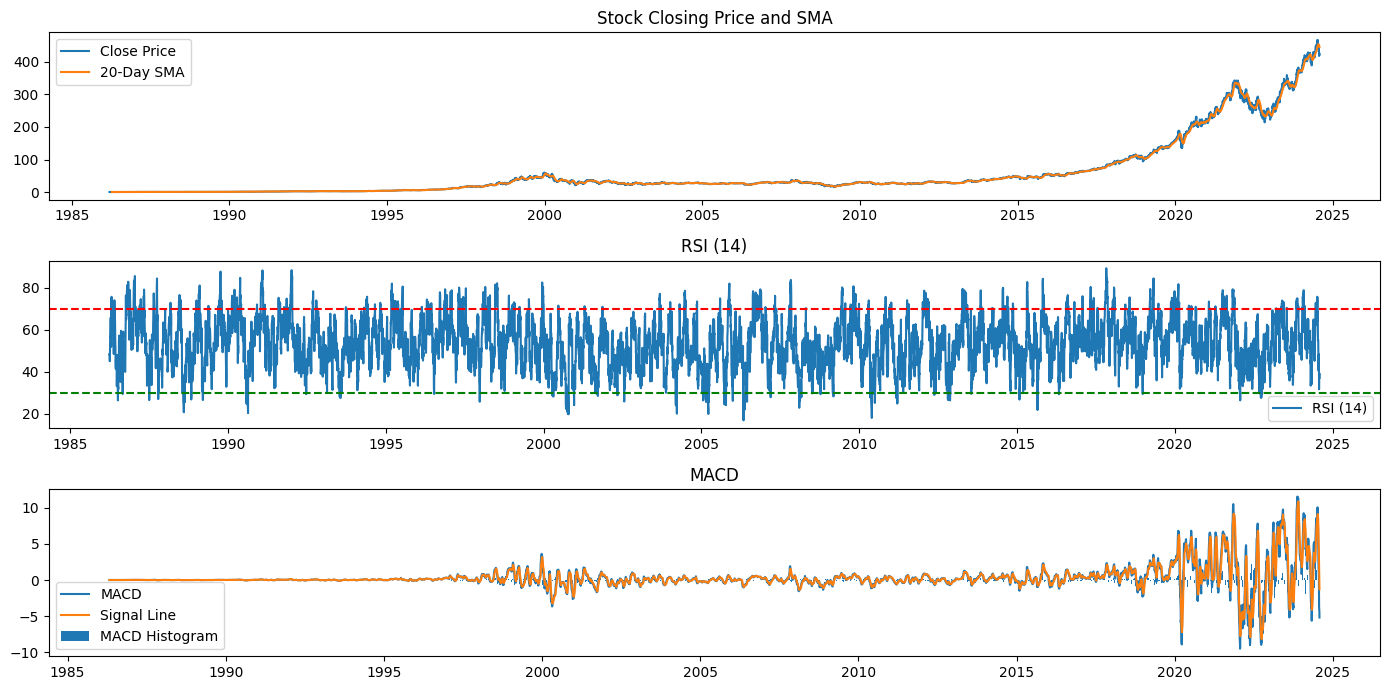

None





NVDA :



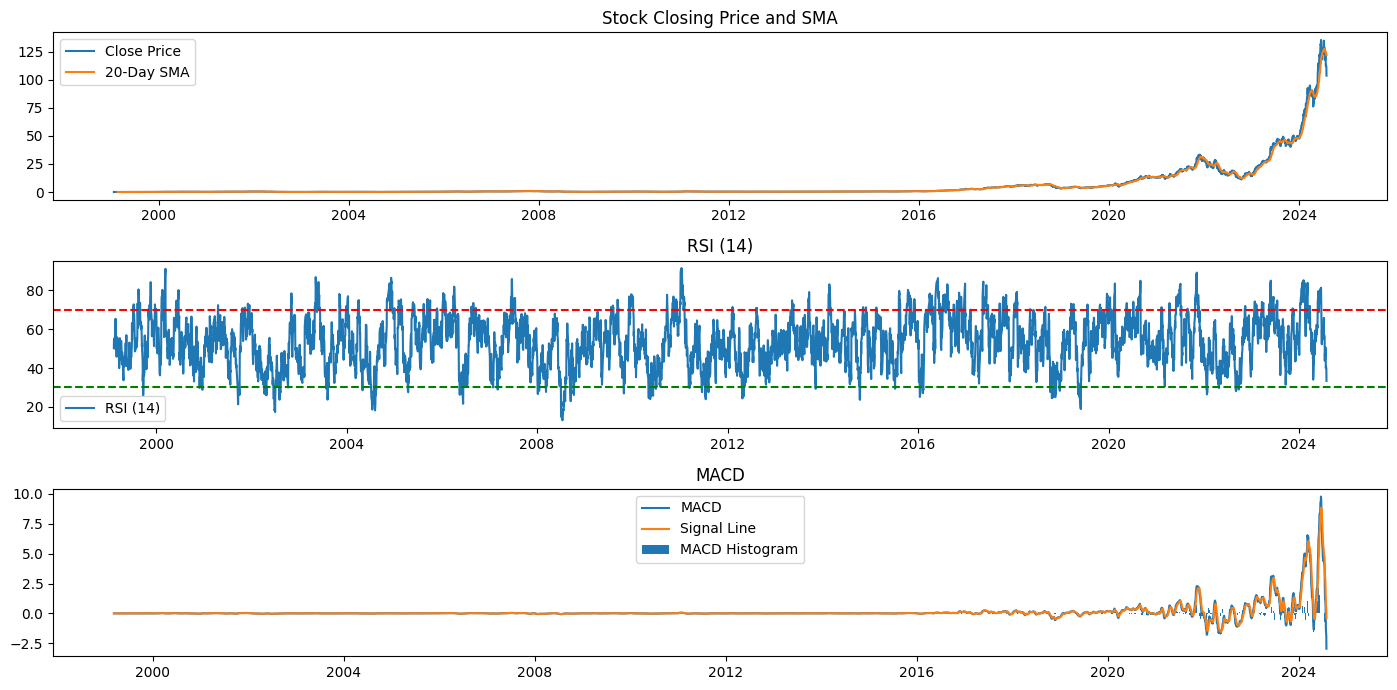

None

In [11]:
import sys
import os
from IPython.display import display # type: ignore
sys.path.append(os.path.abspath('../Scripts'))

company_names = ['AAPL','TSLA','AMZN','GOOG','META','MSFT','NVDA']

stock_data = {}

for company in company_names:
    stock_data[company] = load_stock_data(f'../data/{company}_historical_data.csv')
#stock_data = load_stock_data('../data/AAPL_historical_data.csv')
# Apply technical indicators
    stock_data_with_indicators = apply_technical_indicators(stock_data[company])
# Calculate financial metrics
    stock_data_with_metrics = calculate_financial_metrics(stock_data_with_indicators)
# Visualize the stock data with indicators
    print(f'\n{company} :\n')
    display(visualize_stock_data(stock_data_with_metrics))
    print('\n\n')

## Task 3


In [12]:
import sys
import pandas as pd
import os
from IPython.display import display # type: ignore
sys.path.append(os.path.abspath('../Scripts'))



def load_and_concatenate_stock_data(file_paths):
    data_frames = []
    for file_path in file_paths:
        stock_symbol = os.path.basename(file_path).split('_')[0]
        df = pd.read_csv(file_path)
        df['stock'] = stock_symbol  # Adding 'stock' column
        data_frames.append(df)
    return pd.concat(data_frames, ignore_index=True)

def normalize_dates(news_df, stock_df, date_format='%Y-%m-%d'):
    try:
        news_df['date'] = pd.to_datetime(news_df['date'], utc=True, errors='coerce')
        stock_df['Date'] = pd.to_datetime(stock_df['Date'], utc=True, errors='coerce')
        news_df['date'] = news_df['date'].dt.strftime(date_format)
        stock_df['Date'] = stock_df['Date'].dt.strftime(date_format)
    except Exception as e:
        print(f"Error processing dates: {e}")
        return None

    try:
        merged_df = pd.merge(news_df, stock_df, left_on=['date', 'stock'], right_on=['Date', 'stock'], how='inner')
        return merged_df
    except Exception as e:
        print(f"Error merging data: {e}")
        return None



In [13]:


stock_files = [
    '../data/AAPL_historical_data.csv',
    '../data/AMZN_historical_data.csv',
    '../data/GOOG_historical_data.csv',
    '../data/MSFT_historical_data.csv',
    '../data/META_historical_data.csv',
    '../data/NVDA_historical_data.csv',
    '../data/TSLA_historical_data.csv'
]

# Load news data
news_data = pd.read_csv('../data/raw_analyst_ratings.csv',)

# Load and concatenate stock data
stock_data = load_and_concatenate_stock_data(stock_files)

print(news_data.columns)
print(stock_data.columns)
# news_data = news_data.rename(columns={'date':'Date'})


Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits', 'stock'],
      dtype='object')


In [14]:
# Normalize dates and merge data
merged_data = normalize_dates(sentiment_df, stock_data)

if merged_data is not None:
    print("Date normalization and merging successful!")
    print(merged_data.head())
else:
    print("Failed to normalize and merge data.")
# Assuming 'merged_data' is your DataFrame containing stock prices
# Sort by 'Date' and 'stock' if necessary
merged_data.sort_values(by=['Date', 'stock'], inplace=True)

# Recalculate daily returns after sorting
merged_data['daily_return'] = merged_data.groupby('stock')['Close'].pct_change()
merged_data['daily_return'].fillna(0, inplace=True)

# Display the first few rows to verify the daily returns
print(merged_data[['Date', 'stock', 'Close', 'daily_return']].head())
# Assuming 'merged_data' contains 'date', 'stock', 'sentiment', and 'daily_return' columns
# Group by 'date' and 'stock' and calculate the mean sentiment
average_sentiment = merged_data.groupby(['date', 'stock']).agg({
    'sentiment': 'mean'
}).reset_index()


Date normalization and merging successful!
   Unnamed: 0                                           headline  \
0        7120  Tech Stocks And FAANGS Strong Again To Start D...   
1        7121      10 Biggest Price Target Changes For Wednesday   
2        7122  Benzinga Pro's Top 5 Stocks To Watch For Wed.,...   
3        7123  Deutsche Bank Maintains Buy on Apple, Raises P...   
4        7124  Apple To Let Users Trade In Their Mac Computer...   

                                                 url          publisher  \
0  https://www.benzinga.com/government/20/06/1622...         JJ Kinahan   
1  https://www.benzinga.com/analyst-ratings/price...         Lisa Levin   
2  https://www.benzinga.com/short-sellers/20/06/1...  Benzinga Newsdesk   
3  https://www.benzinga.com/news/20/06/16219873/d...  Benzinga Newsdesk   
4  https://www.benzinga.com/news/20/06/16218697/a...      Neer Varshney   

         date stock  sentiment sentiment_label        Date       Open  \
0  2020-06-10  AAPL     

C:\Users\hp\AppData\Local\Temp\ipykernel_18464\1204553284.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['daily_return'].fillna(0, inplace=True)


In [15]:
# Display the result to verify
print(average_sentiment.head())
# Merge average sentiment with the original dataframe to include daily returns
correlation_data = pd.merge(average_sentiment, merged_data[['date', 'stock', 'daily_return']], on=['date', 'stock'])

# Drop any duplicates that might have occurred during merging
correlation_data = correlation_data.drop_duplicates()

# Display the merged DataFrame to verify
print(correlation_data.head())
# Calculate the Pearson correlation coefficient
correlation_result = correlation_data[['sentiment', 'daily_return']].corr(method='pearson')

print("Correlation between average daily sentiments and daily stock returns for all company at once:")
print(correlation_result)
# Assuming 'correlation_data' contains 'date', 'stock', 'sentiment_score', and 'daily_return' columns
unique_stocks = correlation_data['stock'].unique()  # Get unique stock symbols


         date stock  sentiment
0  2020-06-02  NVDA   0.220200
1  2020-06-04  GOOG   0.000000
2  2020-06-05  GOOG  -0.411033
3  2020-06-08  GOOG   0.542300
4  2020-06-08  NVDA   0.168667
         date stock  sentiment  daily_return
0  2020-06-02  NVDA   0.220200      0.000000
2  2020-06-04  GOOG   0.000000      0.000000
3  2020-06-05  GOOG  -0.411033      0.018560
4  2020-06-05  GOOG  -0.411033      0.000000
6  2020-06-08  GOOG   0.542300      0.005715
Correlation between average daily sentiments and daily stock returns for all company at once:
              sentiment  daily_return
sentiment      1.000000      0.203667
daily_return   0.203667      1.000000


In [16]:

# Initialize a dictionary to store correlation results for each stock
stock_correlations = {}

for stock in unique_stocks:
    # Filter data for each specific stock
    data_filtered = correlation_data[correlation_data['stock'] == stock]
    
    # Calculate the Pearson correlation coefficient for the filtered data
    correlation_result = data_filtered[['sentiment', 'daily_return']].corr(method='pearson')
    
    # Store the correlation result in the dictionary
    stock_correlations[stock] = correlation_result

    # Optionally print the result for each stock
    print(f"Correlation for {stock}:")
    print(correlation_result)
    print("\n")  # Adds a new line for better readability between outputs

Correlation for NVDA:
              sentiment  daily_return
sentiment      1.000000      0.572336
daily_return   0.572336      1.000000


Correlation for GOOG:
              sentiment  daily_return
sentiment      1.000000     -0.265554
daily_return  -0.265554      1.000000


Correlation for AAPL:
              sentiment  daily_return
sentiment           1.0          -0.5
daily_return       -0.5           1.0


Correlation for AMZN:
              sentiment  daily_return
sentiment           1.0           0.5
daily_return        0.5           1.0


Correlation for TSLA:
              sentiment  daily_return
sentiment           NaN           NaN
daily_return        NaN           NaN


